# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109B Data Science 2: Advanced Topics in Data Science 
## AC209B Homework 4: Object Detection and Segmentation


**Harvard University**<br/>
**Spring 2021**<br/>
**Instructors**: Pavlos Protopapas, Mark Glickman, & Chris Tanner 


<hr style="height:2pt">

In [55]:
#RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

<hr style="height:2pt">

### INSTRUCTIONS

- To submit your assignment follow the instructions given in Canvas.

- This homework can be submitted in pairs.

- If you submit individually but you have worked with someone, please include the name of your **one** partner below.
- You need to run this on colab. Please restart the kernel and run the entire notebook again before you submit. (Exception - you may skip the cells where you train neural networks, running the cells which load previously saved weights instead. However, **don't delete/overwrite the output that model.fit produced during training!**)


<hr style="height:2pt">

## Outline: 

<div class='exercise'><b> Question 1: Warming-up | Train segmentation from scratch. [2pts total] </b></div>

*   **1.1** Train the network for 7 epochs with an adam optimizer (lr=0.0001) using randomly initialized weights (`model_from_scratch`).
*   **1.2** Evaluate visually some of the examples. Explain.

<div class='exercise'><b> Question 2: Warming-up 2 | Use pre-trained weights from mobile-net in the encoder. [3pts total] </b></div>

*   **2.1** Train the network for 7 epochs with an adam optimizer (lr=0.0001)(`model_transfer_learning`).
*   **2.2** Write a function to evaluate the DICE metric on the following 3 test images? 
*   **2.3** Evaluate our previous two models quantitively with 3 measures (Validation loss, IoU and DICE), and some qualitively (visual inspection)? Summarize the 3 measures in a pandas Dataframe. (The DICE of the `model_from_scratch` & `model_tranfer_learning` should be around 0.3 and 0.6 respectively.)

<div class='exercise'><b> Question 3: Ablation study | which part is crucial to make this work? [5pts total] </b></div>

*   **3.1 Freeze the encoder [1pts total]**: Is it necessary to train the encoding part if the U-Net is initialized with pretrained weigths? Initialize the encoder with pre-trained weights yet freeze these layers and only train the decoder (=`model_encoding_frozen` ) ?  
*   **3.2 Change the encoder depth: [1pts total]** Do we really need all layers in the encoder?
    - Print the layers of the original MobileNet.
    - `model_encoding_less_deep`: use MobileNet up till layer `block_14_project` as a smaller/less deep encoder, train the model, and calculate the Validation loss, IoU, DICE and store it in the dataframe.
*   **3.3 No skip connections[1pts total]**: Are the skip connection necessary? Omit all skip connection (no concat layers) and calculate the Validation loss, IoU, DICE and store it in the datafram (= `model_no_skip_connection` ). 
*   **3.4 Conclusion [2pts total]**: compare all the models (`model_from_scratch`, `model_transfer_learning`, `model_encoding_frozen`, `model_encoding_early_layers`, `model_encoding_late_layers`, `model_no_skip_connection`) and discuss which parts of the U-Net segmentation transfer learning are crucial? Also do a visual inspection of  `model_encoding_frozen` versus `model_no_skip_connection` and discuss.

<hr style="height:2pt">





In [56]:
!git clone https://github.com/robbertstruyven/transfer_learning.git

import os
os.chdir("transfer_learning")
!ls

Cloning into 'transfer_learning'...
remote: Enumerating objects: 6, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 46004 (delta 2), reused 1 (delta 0), pack-reused 45998
Receiving objects: 100% (46004/46004), 2.49 GiB | 37.24 MiB/s, done.
Resolving deltas: 100% (11662/11662), done.
Checking out files: 100% (18226/18226), done.
deeplab_model.py  ImageSets   model_pretrained.h5  __pycache__
helpers.py	  JPEGImages  model_scratch.h5	   SegmentationClassSubset


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload

Classes to detect, with corresponding colors:


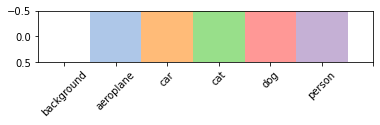

In [57]:
%load_ext autoreload
%autoreload 2
 
%tensorflow_version 2.x

import pandas as pd 
import time

import helpers
from helpers import *


%matplotlib inline
from matplotlib.colors import ListedColormap
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np

start = time.time()

cmap_ref = cm.get_cmap('tab20', 12)
cmap_seg = np.zeros((6, 4))
cmap_seg[0] = [0.7, 0.7, 0.7, 0]
for i in range(1, 6):
  cmap_seg[i] = cmap_ref(i)

cmap_seg = ListedColormap(cmap_seg)
print("\nClasses to detect, with corresponding colors:")
plt.imshow([[0, 1, 2, 3, 4, 5]], cmap=cmap_seg)
plt.xticks([0,1 ,2 ,3 ,4 ,5, 6], LABEL_NAMES[[0, 1, 7, 8, 12, 15]], rotation=45)

INPUT_SPATIAL = 224

In [58]:
source_raw = 'JPEGImages'
source_mask = 'SegmentationClassSubset'

with open('ImageSets/Segmentation/train.txt', 'r') as fp:
    files_train = [line.rstrip() for line in fp.readlines()]

with open('ImageSets/Segmentation/val.txt', 'r') as fp:
    files_val = [line.rstrip() for line in fp.readlines()]

# Filter down to the subset we are using.
files_train = [f for f in files_train if os.path.isfile(os.path.join('SegmentationClassSubset/' + f + '.npy'))]
files_val = [f for f in files_val if os.path.isfile(os.path.join('SegmentationClassSubset/' + f + '.npy'))]

# Split train-validation into 80:20 instead of the original split.
files_all = np.array(sorted(list(set(files_train).union(set(files_val)))))
index = int(len(files_all) * 0.8)
files_train = files_all[:index]
files_val = files_all[index:]
print(len(files_train), 'training', len(files_val), 'validation')
labels = ['background', 'aeroplane', 'car', 'cat', 'dog', 'person']

792 training 199 validation


In [59]:
gen_train = CustomDataGenerator(source_raw=source_raw,
                                source_mask=source_mask,
                                filenames=files_train.copy(),
                                batch_size=4,
                                target_height=INPUT_SPATIAL,
                                target_width=INPUT_SPATIAL)

gen_val = CustomDataGenerator(source_raw=source_raw,
                              source_mask=source_mask,
                              filenames=files_val.copy(),
                              batch_size=4,
                              target_height=INPUT_SPATIAL,
                              target_width=INPUT_SPATIAL)

validation_image_batch = gen_val[0]

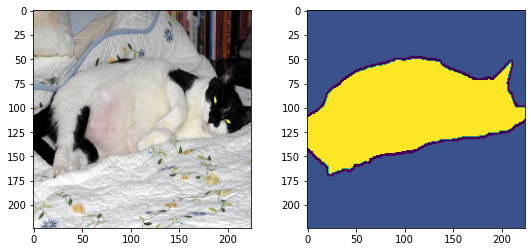

X shape (224, 224, 3) min-mean-max -1.0 0.30537071186165343 1.0
Y shape (224, 224, 1) min-mean-max -1 0.9412268813775511 3


In [60]:
X, Y = gen_train[0]
X = X[0]
Y = Y[0]

plt.figure(figsize=(9, 4))
plt.subplot(1, 2, 1)
plt.imshow(norm_vis(X, mode='rgb'))
plt.subplot(1, 2, 2)
plt.imshow(Y[:, :, 0])
plt.show()

print('X shape', X.shape, 'min-mean-max', X.min(), X.mean(), X.max())
print('Y shape', Y.shape, 'min-mean-max', Y.min(), Y.mean(), Y.max())

## <div class='exercise'><b> Question 1: Warming-up | Train segmentation from scratch. [2pts total] </b></div>


### **1.1 Train the network for 7 epochs with an adam optimizer (lr=0.0001) using randomly initialized weights (`model_from_scratch`)**


In [61]:
K.clear_session()

def get_fcn(pretrained=False, add_activation=True, n_outputs=1):
    def conv_block_simple(prev, num_filters, name):
        return Conv2D(num_filters, activation='relu', kernel_size=(3, 3), padding='same', name=name + '_3x3')(prev)

    selected_encoder = tf.keras.applications.mobilenet_v2.MobileNetV2(
        input_shape=(INPUT_SPATIAL, INPUT_SPATIAL, 3), 
        include_top=False, 
        alpha=1.0,
        weights='imagenet' if pretrained else None)
                
    conv0 = selected_encoder.get_layer("expanded_conv_project").output # 112 x 112
    conv1 = selected_encoder.get_layer("block_2_project").output # 56 x 56
    conv2 = selected_encoder.get_layer("block_5_project").output # 28 x 28
    conv3 = selected_encoder.get_layer("block_12_project").output # 14 x 14
   
    up6 = selected_encoder.output 
    conv7 = up6

    up8 = concatenate([UpSampling2D()(conv7), conv3], axis=-1)
    conv8 = conv_block_simple(up8, 128, "conv8_1")

    up9 = concatenate([UpSampling2D()(conv8), conv2], axis=-1)
    conv9 = conv_block_simple(up9, 64, "conv9_1")

    up10 = concatenate([UpSampling2D()(conv9), conv1], axis=-1)
    conv10 = conv_block_simple(up10, 32, "conv10_1")

    up11 = concatenate([UpSampling2D()(conv10), conv0], axis=-1)
    conv11 = conv_block_simple(up11, 32, "conv11_1")

    up12 = UpSampling2D()(conv11)
    conv12 = conv_block_simple(up12, 32, "conv12_1")

    x = Conv2D(N_CLASSES, (1, 1), activation=None, name="prediction")(conv12)
    
    if add_activation:
      x = tf.keras.layers.Activation("softmax")(x)

    model = tf.keras.Model(selected_encoder.input, [x] * n_outputs)

    return model

In [62]:
def masked_loss(y_true, y_pred):
    """Defines a masked loss that ignores border/unlabeled pixels (represented as -1).
    
    Args:
      y_true: Ground truth tensor of shape [B, H, W, 1].
      y_pred: Prediction tensor of shape [B, H, W, N_CLASSES].
    """
    gt_validity_mask = tf.cast(tf.greater_equal(y_true[:, :, :, 0], 0), dtype=tf.float32) # [B, H, W]
    
    # The sparse categorical crossentropy loss expects labels >= 0. 
    # We just transform -1 into any valid class label, it will then be masked anyways.
    y_true = K.abs(y_true)
    raw_loss = tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred)  # [B, H, W].

    masked = gt_validity_mask * raw_loss
    return tf.reduce_mean(masked)

Create the model here. Compile it. And save it in the `model_from_scratch` variable.

In [63]:
# Write your code here, see notebook of advanced section
# save model as model_from_scratch = ...
number_of_epochs = 7

model_from_scratch = get_fcn(pretrained=False)
model_from_scratch.compile(optimizer=tf.keras.optimizers.Adam(lr=0.0001), loss=masked_loss)
model_from_scratch.save('model_from_scratch')

INFO:tensorflow:Assets written to: model_from_scratch/assets


This is to test you used `model_from_scratch` to save the model:

In [64]:
params_model_from_scratch = model_from_scratch.count_params()
print('Total number of model_from_scratch parameters:', params_model_from_scratch)

Total number of model_from_scratch parameters: 3984166


**Train for 7 epochs while also calculating the validation loss.**
Use `history_model_from_scratch` to store the history.

In [65]:
history_model_from_scratch = model_from_scratch.fit(gen_train, epochs=number_of_epochs, verbose=1, validation_data=gen_val)

Epoch 1/7
198/198 [==============================] - 17s 60ms/step - loss: 1.1618 - val_loss: 1.5604
Epoch 2/7
198/198 [==============================] - 11s 57ms/step - loss: 0.9943 - val_loss: 1.5025
Epoch 3/7
198/198 [==============================] - 11s 57ms/step - loss: 0.9702 - val_loss: 1.4321
Epoch 4/7
198/198 [==============================] - 11s 56ms/step - loss: 0.9644 - val_loss: 1.3821
Epoch 5/7
198/198 [==============================] - 11s 55ms/step - loss: 0.9668 - val_loss: 1.3598
Epoch 6/7
198/198 [==============================] - 11s 55ms/step - loss: 0.9533 - val_loss: 1.2829
Epoch 7/7
198/198 [==============================] - 11s 56ms/step - loss: 0.9159 - val_loss: 1.3300


### **1.2 Evaluate visually some of the examples. Explain.**


In [66]:
def show_examples(model, deeplab=False):
  for i in [2, 13]:
    img = cv2.imread(os.path.join(source_raw, files_val[i] + '.jpg')).astype(np.float32) / 255.
    img = np.flip(img, axis=2)
    img = cv2.resize(img, (256, 256), cv2.INTER_LINEAR)
    gt = np.load(os.path.join(source_mask, files_val[i] + '.npy'))

    ret = run_predict(model, np.expand_dims(img, axis=0), deeplab=deeplab)[0]
    if ret.shape[-1] == 21:
      print("Reducing pedicted classes to the classes to keep.")
      ret = ret[:,:,:,CLASSES_TO_KEEP]
    ret_amax = np.argmax(ret, axis=2)

    plt.figure(figsize=(14, 4))
    plt.subplot(1, 3, 1)
    plt.title('input')
    plt.imshow(norm_vis(img, mode='rgb'))
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title('Ground Truth')
    plt.imshow(norm_vis(img, mode='rgb'))
    plt.imshow(gt[:, :, 0], cmap=cmap_seg, vmin=0, vmax=N_CLASSES, alpha=0.5)
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.title('Prediction')
    plt.imshow(norm_vis(img, mode='rgb'))
    plt.imshow(ret_amax, cmap=cmap_seg, vmin=0, vmax=N_CLASSES, alpha=0.5)
    plt.axis('off')

    plt.figure(figsize=(14, 4))
    for i, label in enumerate(labels[1:]):
        plt.subplot(1, 5, i+1)
        plt.title(label + ': ' + str(round(ret[:, :, i+1].mean(), 2)))
        plt.imshow(ret[:, :, i+1], vmin=0.0, vmax=1.0)
        plt.axis('off')

    plt.show()

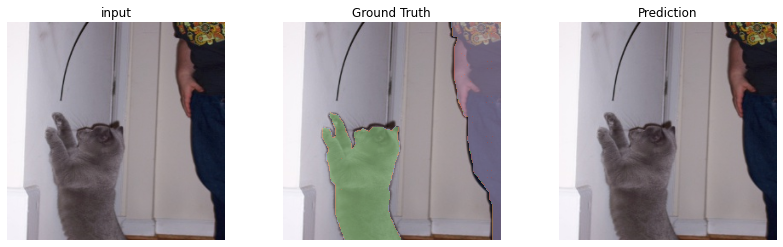

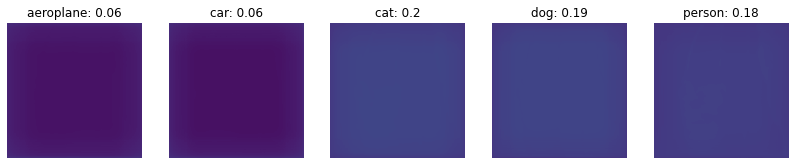

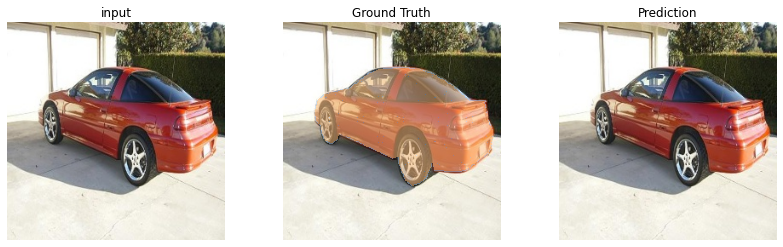

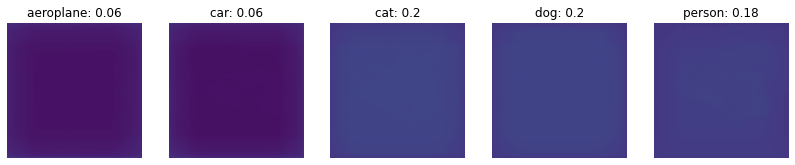

In [67]:
show_examples(model_from_scratch)

*Why is it not working ?*

We have here a very complex architecture, with an important number of parameters, that has no prior knowledge. We expect it to learn from our specific dataset in only 7 epochs, which will not work. Both the regions for semantic segmentation and the predicted classes are predicted in the wrong way, which was fairly expected.

## <div class='exercise'><b> Question 2: Warming-up 2 | Use pre-trained weights from mobile-net in the encoder. [3pts total] </b></div>

### **2.1 Train the network for 7 epochs with an adam optimizer (lr=0.0001)(`model_transfer_learning`)**


Create the model here. Compile it. And save it in the `model_transfer_learning` variable.

In [68]:
# Write your code here 
model_transfer_learning= get_fcn(pretrained= True)

model_transfer_learning.compile(optimizer=tf.keras.optimizers.Adam(lr=0.0001),  # Feel free to play around with the learning rate
                         loss=masked_loss)

print('total number of model parameters:', model_transfer_learning.count_params())

total number of model parameters: 3984166


Test if you have saved the model in the correct variable (do not change or delete!)

In [69]:
params_model_transfer_learning = model_transfer_learning.count_params()
print('Total number of model_from_scratch parameters:\t', params_model_from_scratch)
print('Total number of model_transfer_learning parameters:', params_model_transfer_learning)

Total number of model_from_scratch parameters:	 3984166
Total number of model_transfer_learning parameters: 3984166


**Train the model for 7 epochs (same settings, ADAM, lr = 0.0001, and calculate validation loss).**

Store training history in `history_model_transfer_learning`.

In [70]:
# Write your code here 
history_model_transfer_learning = model_transfer_learning.fit(gen_train, epochs=number_of_epochs, verbose=1, validation_data=gen_val)

Epoch 1/7
198/198 [==============================] - 17s 60ms/step - loss: 1.0238 - val_loss: 0.5569
Epoch 2/7
198/198 [==============================] - 11s 56ms/step - loss: 0.5282 - val_loss: 0.7144
Epoch 3/7
198/198 [==============================] - 11s 57ms/step - loss: 0.4479 - val_loss: 0.4716
Epoch 4/7
198/198 [==============================] - 11s 57ms/step - loss: 0.3871 - val_loss: 0.5234
Epoch 5/7
198/198 [==============================] - 11s 57ms/step - loss: 0.3084 - val_loss: 0.5788
Epoch 6/7
198/198 [==============================] - 11s 57ms/step - loss: 0.2724 - val_loss: 0.4245
Epoch 7/7
198/198 [==============================] - 11s 55ms/step - loss: 0.2675 - val_loss: 0.5235


**Visually how are the result looking?**

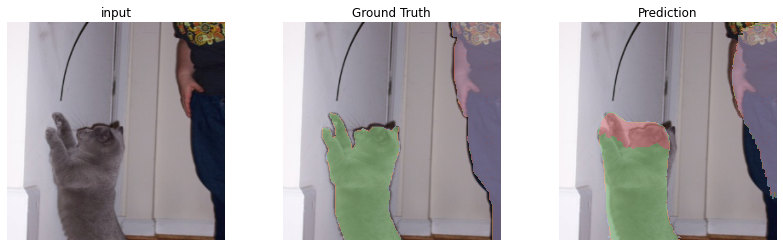

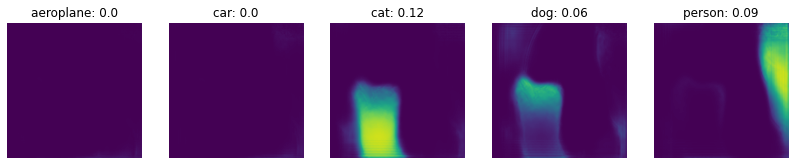

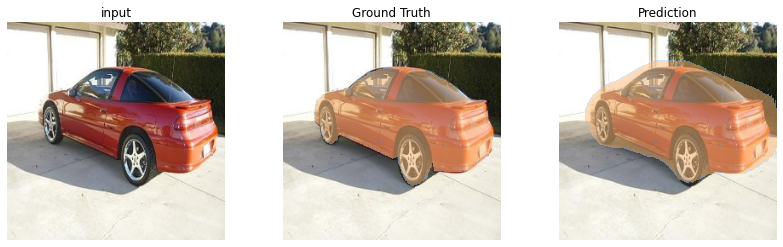

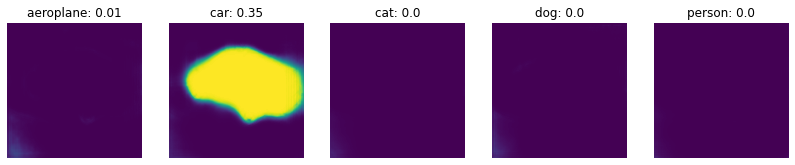

In [71]:
show_examples(model_transfer_learning)

In [109]:
model_transfer_learning.save('model_transfer_learning')

INFO:tensorflow:Assets written to: model_transfer_learning/assets


We can see that leveraging a pre-trained architecture and fine-tuning it on very few epochs for our specific task made a huge contribution: our semantic segmentation is now consistent, produces desirable results in terms of localization and classification. Moreover, we witnessed a way faster training when leveraging pre-trained weights. 

**Training and testing loss?**
- Look at the history callbacks (e.g. `history_model_transfer_learning`) and extract the training and validation loss. 
- Plot both losses for the `history_model_transfer_learning`and `history_model_from_scratch` by running the next cell.**
- Discuss the value of using pre-trained models (transfer learning) here.

In [72]:
def plot_history(histories, titles):
    fig, ax = plt.subplots(1, figsize = (20, 10))
    history_from_scratch = histories[0].history
    history_pretrained = histories[1].history
    ax.plot(history_from_scratch['loss'], label=titles[0] + ' training', color='blue', linestyle='--')
    ax.plot(history_pretrained['loss'], label=titles[1] + ' training', color='blue')
    ax.plot(history_from_scratch['val_loss'], label=titles[0] + ' Validation', color='red', linestyle='--')
    ax.plot(history_pretrained['val_loss'], label=titles[1] + ' Validation', color='red')
    ax.legend()
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.set_title('Visualization of training and validation performances on a pretrained and from scratch model')
    plt.show(fig)
    # Write your code here, see how it is called below

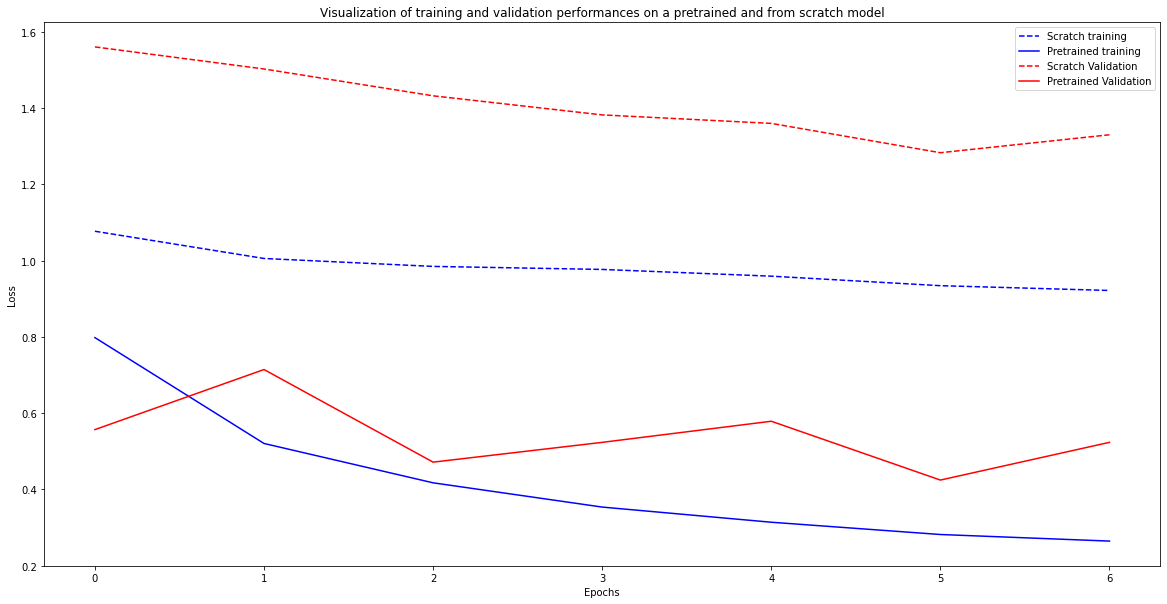

In [73]:
# Do not change:
plot_history([history_model_from_scratch, history_model_transfer_learning], ['Scratch', 'Pretrained'])

We can seethe immediate advantage of leveraging pre-trained models: we don't need to train them, don't need to fine-tune them and don't need to do hyperparameter tuning on large scale datasets in order to use them effectively. This is a huge gain of time + training those big networks would require some hardware that would not always be accessible. 

### **2.2 Write a function to evaluate the DICE metric on the following 3 test images?**

Just because this notebook tested on all the images would take some time we limit us to only look at the 3 first test examples.
Below you see a function to calculate the Intersection over Union. 
Afterwards this function is evaluated on 3 test examples.

In [74]:
# Intersection over union function
def intersection_over_union(y_true, y_pred):
    """Jaccard distance for semantic segmentation.

    Also known as the intersection-over-union loss.
    Jaccard = (|X & Y|) / (|X| + |Y| - |X & Y|)
            = sum(|A * B|) / (sum(|A|)+sum(|B|) - sum(|A * B|))

    Args:
        y_true: Ground truth segmentation mask.
        y_pred: Predicted segmentation mask.
    """
    intersection = np.sum(np.abs(y_true * y_pred))
    sum_ = np.sum(np.abs(y_true) + np.abs(y_pred))
    if (sum_ - intersection) == 0:
      jac = 0
    else: 
      jac = (intersection ) / (sum_ - intersection)
    return jac

In [75]:
# do not change! 
number_of_test_examples = 3

def test_on_n_images(measure, model_used, name, number_of_test_examples):
  weighted_measures = []
  for i in range(number_of_test_examples):
    X, Y = validation_image_batch
    img = X[i]
    truth = cv2.resize(Y[i], (256, 256), interpolation=cv2.INTER_NEAREST)

    ret = run_predict(model_used, np.expand_dims(img, axis=0), deeplab=False)[0]
    arg_max_ret = np.argmax(ret, axis=2)
    
    weighted_measure  = 0
    for c in range(N_CLASSES):
      class_truth = (truth == c).astype(np.float32)
      class_prediction = (arg_max_ret == c).astype(np.float32)
      weighted_measure = weighted_measure + np.sum(class_truth) * measure(class_truth, class_prediction) / (class_truth.shape[0] * class_truth.shape[1])

    print('Test example ' +str(i) + ': For the \t{}\t: measure = \t= {:0.03f}'.format(name, weighted_measure))
    weighted_measures.append(weighted_measure)
  return weighted_measures

iou_model_from_scratch      = test_on_n_images(intersection_over_union, model_from_scratch, 'model_from_scratch', number_of_test_examples)
iou_model_transfer_learning = test_on_n_images(intersection_over_union, model_transfer_learning, 'model_transfer_learning', number_of_test_examples)

Test example 0: For the 	model_from_scratch	: measure = 	= 0.184
Test example 1: For the 	model_from_scratch	: measure = 	= 0.416
Test example 2: For the 	model_from_scratch	: measure = 	= 0.398
Test example 0: For the 	model_transfer_learning	: measure = 	= 0.462
Test example 1: For the 	model_transfer_learning	: measure = 	= 0.403
Test example 2: For the 	model_transfer_learning	: measure = 	= 0.533


In [76]:
print('For the first {} images the average Intersection-over-Union '.format(number_of_test_examples) +
      'for \t the model_from_scratch \t= {:0.03f}'.format(np.mean(iou_model_from_scratch)))

print('For the first {} images the average Intersection-over-Union '.format(number_of_test_examples) +
      'for \t the model_transfer_learning \t= {:0.03f}'.format(np.mean(iou_model_transfer_learning)))

For the first 3 images the average Intersection-over-Union for 	 the model_from_scratch 	= 0.333
For the first 3 images the average Intersection-over-Union for 	 the model_transfer_learning 	= 0.466


We can see that this metrics succesfully captures our intuition and the training dynamics from our neural networks: the transfer learning model is consistently better than the one trained from scratch. 

### 2.3 **Implement the DICE measure calculation and run it on the same 3 test images.**

In [77]:
def DICE(y_true, y_pred):
    # Write your code here, for the DICE measure calculation
    intersection = np.sum(np.abs(y_true * y_pred))
    sum_ = np.sum(np.abs(y_true) + np.abs(y_pred))
    if (sum_ + intersection) == 0:
      dice = 0
    else:
      dice = 2*(intersection ) / (sum_ )
    return dice

In [78]:
## Do not change, do run!
dice_model_from_scratch      = test_on_n_images(DICE, model_from_scratch, 'model_from_scratch', number_of_test_examples)
dice_model_transfer_learning = test_on_n_images(DICE, model_transfer_learning, 'model_transfer_learning', number_of_test_examples)

Test example 0: For the 	model_from_scratch	: measure = 	= 0.258
Test example 1: For the 	model_from_scratch	: measure = 	= 0.505
Test example 2: For the 	model_from_scratch	: measure = 	= 0.488
Test example 0: For the 	model_transfer_learning	: measure = 	= 0.589
Test example 1: For the 	model_transfer_learning	: measure = 	= 0.496
Test example 2: For the 	model_transfer_learning	: measure = 	= 0.626


In [79]:
print('For the first {} images the average DICE '.format(number_of_test_examples) +
      'for \t the model_from_scratch \t= {:0.03f}'.format(np.mean(dice_model_from_scratch)))

print('For the first {} images the average DICE '.format(number_of_test_examples) +
      'for \t the model_transfer_learning \t= {:0.03f}'.format(np.mean(dice_model_transfer_learning)))

For the first 3 images the average DICE for 	 the model_from_scratch 	= 0.417
For the first 3 images the average DICE for 	 the model_transfer_learning 	= 0.570


**What is the meaning of the DICE measure? Compare it with the IoU?**

From the Advanced Sections, we have seen that the IoU is a way to measure how well we fit the objective bounding box. However, this measure is not conservative, this is why we introduced the DICE measure which emphasizes more on the True Positives. The DICE measure is the equivalent of the F1 measure for classical classification models we have seen.

The next cell normally summarizes all results so far in a pandas dataframe.

In [80]:
IOU = [np.mean(iou_model_from_scratch), 
       np.mean(iou_model_transfer_learning)]

dice = [np.mean(dice_model_from_scratch), 
        np.mean(dice_model_transfer_learning)]

validation_loss = [history_model_from_scratch.history['val_loss'][-1],
                   history_model_transfer_learning.history['val_loss'][-1]]

names  = ['model_from_scratch', 
          'model_transfer_learning']

df = pd.DataFrame({'IOU': IOU, 'DICE': dice, 'Validation_loss': validation_loss}, index = names).round(3)
df

,IOU,DICE,Validation_loss
model_from_scratch,0.333,0.417,1.330
model_transfer_learning,0.466,0.570,0.523


These results are expected since both metrics are positively correlated (https://stats.stackexchange.com/questions/273537/f1-dice-score-vs-iou): 

$$
\text{Dice} = \frac{2*IoU}{IoU+1} \text{ and } x\mapsto\frac{2x}{x+1} \text{ is strictly increasing.}
$$

## <div class='exercise'><b> Question 3: Ablation study | which part is crucial to make this work? [5pts total] </b></div>

In a ablation study, researcher look for which part of their new method is crucial for the State-of-the-Art (SOTA) performance. We will perform an ablation study on the U-Net by 
 - freezing the encoder part and look at performance
 - change the encoder depth and look at performance
 - omit the skip-connections in the U-Net and look at performance.

Ablation studies are common in computer science and specifically in computer vision. 

Here is a typical table how an (inverse) ablation study looks in literature. They also use DICE and mIoU (mean Intersection-over-Union)as we do. 

-----
 ![ablation study](https://www.researchgate.net/profile/Huazhu_Fu/publication/334694889/figure/tbl2/AS:784753808654337@1564111296559/Ablation-study-of-optic-disc-cup-segmentation-on-the-Drishti-GS-test-set.png)


 --------


### **3.1 Freeze the encoder [1pts total]**: 
Is it necessary to train the encoding part if the U-Net is initialized with pretrained weigths? Initialize the encoder with pre-trained weights yet freeze these layers and only train the decoder (=`model_encoding_frozen` ) ?  

In [81]:
def get_fcn_frozen(pretrained=True, add_activation=True, n_outputs=1):
    def conv_block_simple(prev, num_filters, name):
        return Conv2D(num_filters, activation='relu', kernel_size=(3, 3), padding='same', name=name + '_3x3')(prev)

    selected_encoder = tf.keras.applications.mobilenet_v2.MobileNetV2(
        input_shape=(INPUT_SPATIAL, INPUT_SPATIAL, 3), 
        include_top=False, 
        alpha=1.0,
        weights='imagenet' if pretrained else None)
    
    # Write your code here, make all the layers of the encoder untrainable
    for l in selected_encoder.layers:
        l.trainable = False
    # stop writing code here

    conv0 = selected_encoder.get_layer("expanded_conv_project").output # 112 x 112
    conv1 = selected_encoder.get_layer("block_2_project").output # 56 x 56
    conv2 = selected_encoder.get_layer("block_5_project").output # 28 x 28
    conv3 = selected_encoder.get_layer("block_12_project").output # 14 x 14
   
    up6 = selected_encoder.output 
    conv7 = up6

    up8 = concatenate([UpSampling2D()(conv7), conv3], axis=-1)
    conv8 = conv_block_simple(up8, 128, "conv8_1")

    up9 = concatenate([UpSampling2D()(conv8), conv2], axis=-1)
    conv9 = conv_block_simple(up9, 64, "conv9_1")

    up10 = concatenate([UpSampling2D()(conv9), conv1], axis=-1)
    conv10 = conv_block_simple(up10, 32, "conv10_1")

    up11 = concatenate([UpSampling2D()(conv10), conv0], axis=-1)
    conv11 = conv_block_simple(up11, 32, "conv11_1")

    up12 = UpSampling2D()(conv11)
    conv12 = conv_block_simple(up12, 32, "conv12_1")

    x = Conv2D(N_CLASSES, (1, 1), activation=None, name="prediction")(conv12)
    
    if add_activation:
      x = tf.keras.layers.Activation("softmax")(x)

    model = tf.keras.Model(selected_encoder.input, [x] * n_outputs)

    return model

Create, compile and store the model in `model_encoding_frozen`.

In [82]:
# Write your code here 
model_encoding_frozen= get_fcn_frozen(pretrained= True)

model_encoding_frozen.compile(optimizer=tf.keras.optimizers.Adam(lr=0.0001),  # Feel free to play around with the learning rate
                         loss=masked_loss)

In [83]:
params_model_encoding_frozen = model_encoding_frozen.count_params()

**The frozen model should have the same number of total parameters? Check this**

In [84]:
# Your code here 
print('The number of parameters for the frozen model is ', params_model_encoding_frozen)
print('Non frozen', params_model_transfer_learning)

The number of parameters for the frozen model is  3984166
Non frozen 3984166


**However, The frozen model should have the LESS trainable parameters?**

In [85]:
def get_trainable_params(model):
  trainable_count = np.sum([K.count_params(w) for w in model.trainable_weights])
  return trainable_count

In [86]:
# Your code here 
params_trainable_model_from_scratch      = get_trainable_params(model_from_scratch)
params_trainable_model_transfer_learning = get_trainable_params(model_transfer_learning)
params_trainable_model_encoding_frozen   = get_trainable_params(model_encoding_frozen)

print('Total number of model_from_scratch TRAINABLE parameters:\t',      params_trainable_model_from_scratch)
print('Total number of model_transfer_learning TRAINABLE parameters:\t', params_trainable_model_transfer_learning)
print('Total number of model_encoding_frozen TRAINABLE parameters:\t',   params_trainable_model_encoding_frozen)

Total number of model_from_scratch TRAINABLE parameters:	 3950054
Total number of model_transfer_learning TRAINABLE parameters:	 3950054
Total number of model_encoding_frozen TRAINABLE parameters:	 1726182


**Train the model for 7 epochs (same settings, ADAM, lr = 0.0001, and calculate validation loss).**

Store training history in `history_model_encoding_frozen`.

In [87]:
history_model_encoding_frozen = model_encoding_frozen.fit(gen_train, epochs=number_of_epochs, verbose=1, validation_data=gen_val)

Epoch 1/7
198/198 [==============================] - 9s 34ms/step - loss: 1.1404 - val_loss: 0.5559
Epoch 2/7
198/198 [==============================] - 6s 30ms/step - loss: 0.4438 - val_loss: 0.4225
Epoch 3/7
198/198 [==============================] - 6s 29ms/step - loss: 0.3637 - val_loss: 0.4183
Epoch 4/7
198/198 [==============================] - 6s 29ms/step - loss: 0.3079 - val_loss: 0.4046
Epoch 5/7
198/198 [==============================] - 6s 29ms/step - loss: 0.2730 - val_loss: 0.3805
Epoch 6/7
198/198 [==============================] - 6s 29ms/step - loss: 0.2428 - val_loss: 0.3967
Epoch 7/7
198/198 [==============================] - 6s 29ms/step - loss: 0.2294 - val_loss: 0.3749


In [110]:
model_encoding_frozen.save('model_encoding_frozen')

INFO:tensorflow:Assets written to: model_encoding_frozen/assets


**Calculating the iou and dice**

In [88]:
iou_model_encoding_frozen       = test_on_n_images(intersection_over_union, model_encoding_frozen, 'model_encoding_frozen', number_of_test_examples)
dice_model_encoding_frozen      = test_on_n_images(DICE, model_encoding_frozen, 'model_encoding_frozen', number_of_test_examples)

Test example 0: For the 	model_encoding_frozen	: measure = 	= 0.438
Test example 1: For the 	model_encoding_frozen	: measure = 	= 0.411
Test example 2: For the 	model_encoding_frozen	: measure = 	= 0.504
Test example 0: For the 	model_encoding_frozen	: measure = 	= 0.570
Test example 1: For the 	model_encoding_frozen	: measure = 	= 0.519
Test example 2: For the 	model_encoding_frozen	: measure = 	= 0.613


**Let's look at performance, discuss:**

In [89]:
IOU = [np.mean(iou_model_from_scratch), 
       np.mean(iou_model_transfer_learning),
       np.mean(iou_model_encoding_frozen)]

dice = [np.mean(dice_model_from_scratch), 
        np.mean(dice_model_transfer_learning),
        np.mean(dice_model_encoding_frozen)]

validation_loss = [history_model_from_scratch.history['val_loss'][-1],
                   history_model_transfer_learning.history['val_loss'][-1],
                   history_model_encoding_frozen.history['val_loss'][-1]]

params = [params_model_from_scratch,
          params_model_transfer_learning,
          params_model_encoding_frozen]

trainable = [params_trainable_model_from_scratch, 
             params_trainable_model_transfer_learning, 
             params_trainable_model_encoding_frozen]

names  = ['model_from_scratch', 
          'model_transfer_learning',
          'model_encoding_frozen']

df = pd.DataFrame({'Parameters': params, 'Trainable params': trainable, 
                   'IOU': IOU, 'DICE': dice, 'Validation_loss': validation_loss}, index = names).round(3)
df

,Parameters,Trainable params,IOU,DICE,Validation_loss
model_from_scratch,3984166,3950054,0.333,0.417,1.330
model_transfer_learning,3984166,3950054,0.466,0.570,0.523
model_encoding_frozen,3984166,1726182,0.451,0.567,0.375


Something interesting arises from this summary: although the metrics are lower for the frozen model (which was expected, we want to fine-tune the encoder on our specific task), the validation loss is better for the frozen model than with the entire model. I think this is due to the fact that the frozen model presents less learnable parameters, therefore the optimization landscape is smoother for its loss function, explaining why it finds better local optima in terms of the loss function. However, we do not measure performance based on loss performances, but rather on metrics that try to capture the expected behaviour (whereas the loss is only a differentiable proxy for these metrics).

### **3.2 Change the encoder depth: [1pts total]** 

**Do we really need all layers in the encoder?**

Print the summary and the layers of the original MobileNet:

In [90]:
# Write your code here
selected_encoder = tf.keras.applications.mobilenet_v2.MobileNetV2(input_shape=(INPUT_SPATIAL, INPUT_SPATIAL, 3), include_top=False, alpha=1.0, weights='imagenet')
print(selected_encoder.summary())

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_4[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
_______________________________________________________________________________

Built a subversion of the MobileNet. Just have layer `block_12_project` as your output. This will later be used in your less deep encoded U-Net.

- The `intermediate_layer_model` should have approximately 500k parameters, 

In [91]:

layer_name = 'block_12_project'

# Your code here
last_conv_layer = selected_encoder.get_layer(layer_name)
layer_input = selected_encoder.inputs
layer_output = last_conv_layer.output
# Stop writing code here

# Construction of the model given:
intermediate_layer_model = tf.keras.Model([layer_input], outputs = [layer_output])

params_model_encoding_less_deep = intermediate_layer_model.count_params()
params_trainable_model_encoding_less_deep   = get_trainable_params(intermediate_layer_model)

In [92]:
print('Total number of model_encoding_less_deep parameters:\t', params_model_encoding_less_deep)
print('Total number of model_encoding_less_deep TRAINABLE parameters:\t',   params_trainable_model_encoding_less_deep)

Total number of model_encoding_less_deep parameters:	 558272
Total number of model_encoding_less_deep TRAINABLE parameters:	 542336


**`model_encoding_less_deep`: use MobileNet up till layer `block_12_project` as a smaller/less deep encoder**

- your `intermediate_layer_model` is the input of the get_fcn_less_deep() function.
- you should only have 3 skip connections (expanded_conv_project, block_2_project, block_5_project)
- you should not have a conv 3 downsampling and also not the first upsampling conv7 layer.
- up6 = intermediate_layer_model.output 

In [93]:
def get_fcn_less_deep(encoder = intermediate_layer_model, add_activation=True, n_outputs=1):
    def conv_block_simple(prev, num_filters, name):
        return Conv2D(num_filters, activation='relu', kernel_size=(3, 3), padding='same', name=name + '_3x3')(prev)
    
    conv0 = encoder.get_layer("expanded_conv_project").output # 112 x 112
    conv1 = encoder.get_layer("block_2_project").output # 56 x 56
    conv2 = encoder.get_layer("block_5_project").output # 28 x 28

    # Write your code here: Your code here should not have a conv3 and no conv 7
    up6 = encoder.output 
    conv8 = conv_block_simple(up6, 128, "conv8_1")

    up9 = concatenate([UpSampling2D()(conv8), conv2], axis=-1)
    # Stop writing code here


    conv9 = conv_block_simple(up9, 64, "conv9_1")

    up10 = concatenate([UpSampling2D()(conv9), conv1], axis=-1)
    conv10 = conv_block_simple(up10, 32, "conv10_1")

    up11 = concatenate([UpSampling2D()(conv10), conv0], axis=-1)
    conv11 = conv_block_simple(up11, 32, "conv11_1")

    up12 = UpSampling2D()(conv11)
    conv12 = conv_block_simple(up12, 32, "conv12_1")

    x = Conv2D(N_CLASSES, (1, 1), activation=None, name="prediction")(conv12)
    
    if add_activation:
      x = tf.keras.layers.Activation("softmax")(x)

    model = tf.keras.Model(encoder.input, [x] * n_outputs)

    return model

Create the model here. Compile it. And save it in the `model_encoding_less_deep` variable.

In [94]:
# Write your code here 
model_encoding_less_deep = get_fcn_less_deep()
model_encoding_less_deep.compile(optimizer=tf.keras.optimizers.Adam(lr=0.0001),  # Feel free to play around with the learning rate
                         loss=masked_loss)

In [95]:
print('Total number of model_encoding_less_deep parameters:\t', params_model_encoding_less_deep)
print('Total number of model_encoding_less_deep TRAINABLE parameters:\t',   params_trainable_model_encoding_less_deep)

Total number of model_encoding_less_deep parameters:	 558272
Total number of model_encoding_less_deep TRAINABLE parameters:	 542336


**Train for 7 epochs while also calculating the validation loss.**
Use `history_model_encoding_less_deep` to store the history.

In [96]:
# Write your code here 
history_model_encoding_less_deep = model_encoding_less_deep.fit(gen_train, epochs=number_of_epochs, verbose=1, validation_data=gen_val)

Epoch 1/7
198/198 [==============================] - 14s 52ms/step - loss: 1.2475 - val_loss: 0.8527
Epoch 2/7
198/198 [==============================] - 10s 48ms/step - loss: 0.7596 - val_loss: 0.5921
Epoch 3/7
198/198 [==============================] - 10s 49ms/step - loss: 0.5892 - val_loss: 0.4791
Epoch 4/7
198/198 [==============================] - 10s 49ms/step - loss: 0.4969 - val_loss: 0.4467
Epoch 5/7
198/198 [==============================] - 10s 48ms/step - loss: 0.4560 - val_loss: 0.4309
Epoch 6/7
198/198 [==============================] - 10s 48ms/step - loss: 0.4410 - val_loss: 0.4451
Epoch 7/7
198/198 [==============================] - 10s 48ms/step - loss: 0.4316 - val_loss: 0.4474


In [111]:
model_encoding_less_deep.save('model_encoding_less_deep')

INFO:tensorflow:Assets written to: model_encoding_less_deep/assets


In [97]:
iou_model_encoding_less_deep       = test_on_n_images(intersection_over_union, model_encoding_less_deep, 'model_encoding_less_deep', number_of_test_examples)
dice_model_encoding_less_deep      = test_on_n_images(DICE, model_encoding_less_deep, 'model_encoding_less_deep', number_of_test_examples)

Test example 0: For the 	model_encoding_less_deep	: measure = 	= 0.511
Test example 1: For the 	model_encoding_less_deep	: measure = 	= 0.387
Test example 2: For the 	model_encoding_less_deep	: measure = 	= 0.470
Test example 0: For the 	model_encoding_less_deep	: measure = 	= 0.626
Test example 1: For the 	model_encoding_less_deep	: measure = 	= 0.508
Test example 2: For the 	model_encoding_less_deep	: measure = 	= 0.595


In [98]:
IOU = [np.mean(iou_model_from_scratch), 
       np.mean(iou_model_transfer_learning),
       np.mean(iou_model_encoding_frozen),
       np.mean(iou_model_encoding_less_deep)]

dice = [np.mean(dice_model_from_scratch), 
        np.mean(dice_model_transfer_learning),
        np.mean(dice_model_encoding_frozen),
        np.mean(dice_model_encoding_less_deep)]

validation_loss = [history_model_from_scratch.history['val_loss'][-1],
                   history_model_transfer_learning.history['val_loss'][-1],
                   history_model_encoding_frozen.history['val_loss'][-1],
                   history_model_encoding_less_deep.history['val_loss'][-1]]

params = [params_model_from_scratch,
          params_model_transfer_learning,
          params_model_encoding_frozen,
          params_model_encoding_less_deep]

trainable = [params_trainable_model_from_scratch, 
             params_trainable_model_transfer_learning, 
             params_trainable_model_encoding_frozen, 
             params_trainable_model_encoding_less_deep]

names  = ['model_from_scratch', 
          'model_transfer_learning',
          'model_encoding_frozen',
          'model_encoding_less_deep']

df = pd.DataFrame({'Parameters': params, 'Trainable params': trainable, 
                   'IOU': IOU, 'DICE': dice, 'Validation_loss': validation_loss}, index = names).round(3)
df

,Parameters,Trainable params,IOU,DICE,Validation_loss
model_from_scratch,3984166,3950054,0.333,0.417,1.330
model_transfer_learning,3984166,3950054,0.466,0.570,0.523
model_encoding_frozen,3984166,1726182,0.451,0.567,0.375
model_encoding_less_deep,558272,542336,0.456,0.576,0.447


### **3.3 No skip connections[1pts total]**: 

Are the skip connection necessary? Omit all the skip connection (no concat layers).
- no conv0, conv1, conv2, conv3 needed since these are the skip-connection!

In [99]:
def get_fcn_no_skip(pretrained=True, add_activation=True, n_outputs=1):
    def conv_block_simple(prev, num_filters, name):
        return Conv2D(num_filters, activation='relu', kernel_size=(3, 3), padding='same', name=name + '_3x3')(prev)

    selected_encoder = tf.keras.applications.mobilenet_v2.MobileNetV2(
        input_shape=(INPUT_SPATIAL, INPUT_SPATIAL, 3), 
        include_top=False, 
        alpha=1.0,
        weights='imagenet' if pretrained else None)
    
    conv0 = selected_encoder.get_layer("expanded_conv_project").output # 112 x 112
    conv1 = selected_encoder.get_layer("block_2_project").output # 56 x 56
    conv2 = selected_encoder.get_layer("block_5_project").output # 28 x 28
    conv3 = selected_encoder.get_layer("block_12_project").output # 14 x 14
   
    up6 = selected_encoder.output 
    conv7 = up6

    up6 = selected_encoder.output 
    conv7 = up6

    up8 = UpSampling2D()(conv7)
    conv8 = conv_block_simple(up8, 128, "conv8_1")

    up9 = UpSampling2D()(conv8)
    conv9 = conv_block_simple(up9, 64, "conv9_1")

    up10 = UpSampling2D()(conv9)
    conv10 = conv_block_simple(up10, 32, "conv10_1")

    up11 = UpSampling2D()(conv10)
    conv11 = conv_block_simple(up11, 32, "conv11_1")

    up12 = UpSampling2D()(conv11)
    conv12 = conv_block_simple(up12, 32, "conv12_1")


    # Your code here
    
    x = Conv2D(N_CLASSES, (1, 1), activation=None, name="prediction")(conv12)
    
    if add_activation:
      x = tf.keras.layers.Activation("softmax")(x)

    model = tf.keras.Model(selected_encoder.input, [x] * n_outputs)

    return model

**Create the model here. Compile it. And save it in the `model_no_skip` variable.**

In [100]:
# Write your code here 
model_no_skip = get_fcn_no_skip()
model_no_skip.compile(optimizer=tf.keras.optimizers.Adam(lr=0.0001),  # Feel free to play around with the learning rate
                         loss=masked_loss)

**Train for 7 epochs while also calculating the validation loss.** Use `history_model_no_skip` to store the history.

In [101]:
# Write your code here 
history_model_no_skip = model_no_skip.fit(gen_train, epochs=number_of_epochs, verbose=1, validation_data=gen_val)

Epoch 1/7
198/198 [==============================] - 15s 59ms/step - loss: 0.9660 - val_loss: 2.2628
Epoch 2/7
198/198 [==============================] - 11s 55ms/step - loss: 0.5651 - val_loss: 1.0146
Epoch 3/7
198/198 [==============================] - 11s 55ms/step - loss: 0.4433 - val_loss: 0.8632
Epoch 4/7
198/198 [==============================] - 11s 55ms/step - loss: 0.3892 - val_loss: 1.3916
Epoch 5/7
198/198 [==============================] - 11s 56ms/step - loss: 0.3560 - val_loss: 0.7478
Epoch 6/7
198/198 [==============================] - 11s 55ms/step - loss: 0.3166 - val_loss: 0.7462
Epoch 7/7
198/198 [==============================] - 11s 54ms/step - loss: 0.2778 - val_loss: 0.4921


In [112]:
model_no_skip.save('model_no_skip')

INFO:tensorflow:Assets written to: model_no_skip/assets


**calculating the Validation loss, IoU, DICE and store it in the datafram (= `model_no_skip_connection` ).**

In [102]:
iou_model_no_skip       = test_on_n_images(intersection_over_union, model_no_skip, 'model_no_skip', number_of_test_examples)
dice_model_no_skip      = test_on_n_images(DICE                   , model_no_skip, 'model_no_skip', number_of_test_examples)

Test example 0: For the 	model_no_skip	: measure = 	= 0.506
Test example 1: For the 	model_no_skip	: measure = 	= 0.448
Test example 2: For the 	model_no_skip	: measure = 	= 0.480
Test example 0: For the 	model_no_skip	: measure = 	= 0.623
Test example 1: For the 	model_no_skip	: measure = 	= 0.529
Test example 2: For the 	model_no_skip	: measure = 	= 0.592


In [103]:
params_model_no_skip = model_no_skip.count_params()
params_trainable_model_no_skip   = get_trainable_params(model_no_skip)

In [104]:
IOU = [np.mean(iou_model_from_scratch), 
       np.mean(iou_model_transfer_learning),
       np.mean(iou_model_encoding_frozen),
       np.mean(iou_model_encoding_less_deep),
       np.mean(iou_model_no_skip)]

dice = [np.mean(dice_model_from_scratch), 
        np.mean(dice_model_transfer_learning),
        np.mean(dice_model_encoding_frozen),
        np.mean(dice_model_encoding_less_deep),
        np.mean(dice_model_no_skip)]

validation_loss = [history_model_from_scratch.history['val_loss'][-1],
                   history_model_transfer_learning.history['val_loss'][-1],
                   history_model_encoding_frozen.history['val_loss'][-1],
                   history_model_encoding_less_deep.history['val_loss'][-1],
                   history_model_no_skip.history['val_loss'][-1]]

params = [params_model_from_scratch,
          params_model_transfer_learning,
          params_model_encoding_frozen,
          params_model_encoding_less_deep,
          params_model_no_skip,]

trainable = [params_trainable_model_from_scratch, 
             params_trainable_model_transfer_learning, 
             params_trainable_model_encoding_frozen, 
             params_trainable_model_encoding_less_deep, 
             params_trainable_model_no_skip]

names  = ['model_from_scratch', 
          'model_transfer_learning',
          'model_encoding_frozen',
          'model_encoding_less_deep',
          'model_no_skip']

df = pd.DataFrame({'Parameters': params, 'Trainable params': trainable, 
                   'IOU': IOU, 'DICE': dice, 'Validation_loss': validation_loss}, index = names).round(3)

### **3.4 Conclusion [2pts total]**:

compare all the models (`model_from_scratch`, `model_transfer_learning`, `model_encoding_frozen`, `model_encoding_early_layers`, `model_encoding_late_layers`, `model_no_skip_connection`) and discuss which parts of the U-Net segmentation transfer learning are crucial?

In [105]:
df

,Parameters,Trainable params,IOU,DICE,Validation_loss
model_from_scratch,3984166,3950054,0.333,0.417,1.330
model_transfer_learning,3984166,3950054,0.466,0.570,0.523
model_encoding_frozen,3984166,1726182,0.451,0.567,0.375
model_encoding_less_deep,558272,542336,0.456,0.576,0.447
model_no_skip,3843622,3809510,0.478,0.581,0.492


From the ablation study, we can see that different parts of of the U-Net segmentation transfer learning are crucial:
- Training the encoder: training the encoder prevents from having a 'simple' optimization landscape and makes optimization harder, which explains why the validation loss is lower when freezing it. However, we can see that freezing it drops dramatically the performances in terms of DICE or IoU: training the encoder is **crucial**. Training the encoder is actually the most important part of the network, given the performances in terms of DICE and IoU. 
- The depth of the encoder: the depth of the encoder is actually not that important according to our ablatio study  
- Last, the skip connections for image reconstruction are the less important parts of the network in terms of metrics for IoU and DICE, and removing some actully improves the quality of our networks

**Also do a visual inspection of  `model_transfer_learning` versus `model_no_skip_connection`, look for example at the car or cat heatmap and discuss. Why do skip connection help?**

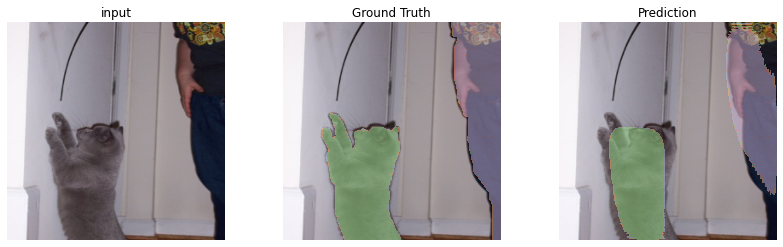

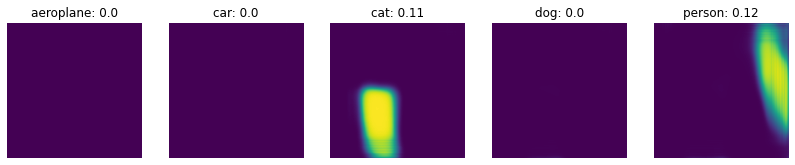

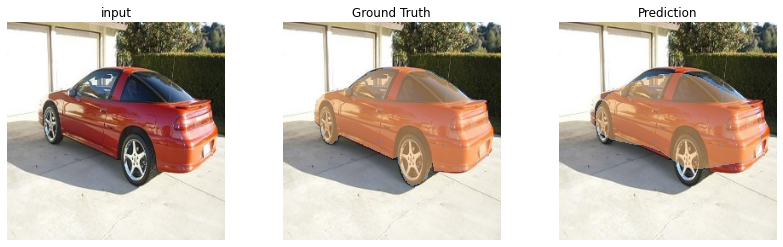

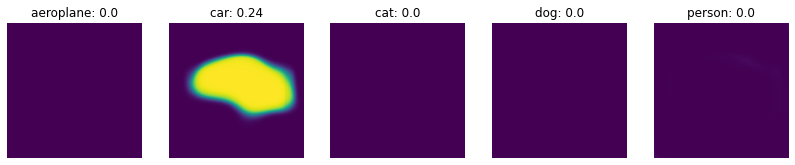

In [106]:
show_examples(model_no_skip)

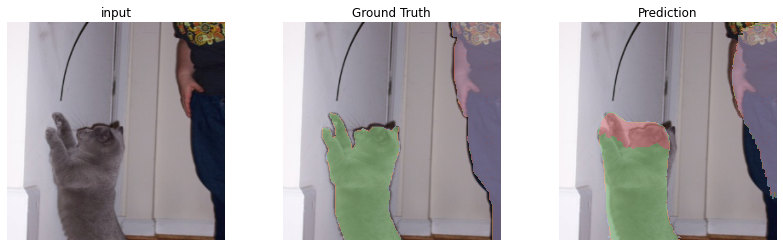

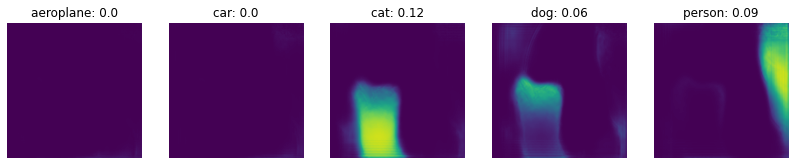

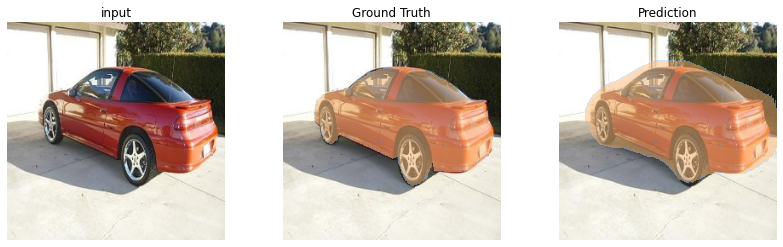

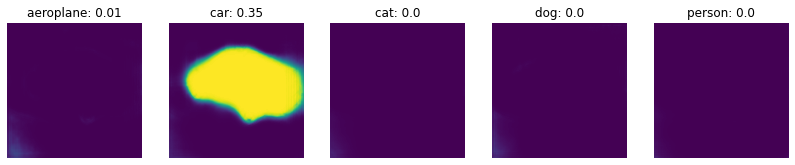

In [107]:
show_examples(model_transfer_learning)

Skip connections help with **strength** of the gradients. We can see that pixel intensities when using skip connections/not using skip connections are very different  Using skip connections allow information to flow in an easier way in order to not lost this information in the process of backpropagation/activations/different blocks. 

In [108]:
end = time.time()
print('This total notebook took : {} minutes to run!'.format(round((end-start)/60)))

This total notebook took : 14 minutes to run!
